# SVM trained by SMO

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 准备数据集

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
datasets = [train_data, test_data]

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
to_drop = ['Name', 'Ticket', 'Cabin', 'Embarked', 'PassengerId']

for dataset in datasets:
    dataset.drop(to_drop,axis=1,inplace=True)
    dataset.replace(to_replace='male',value=1,inplace=True)
    dataset.replace(to_replace='female',value=0,inplace=True)
    dataset['Age'].fillna(value=dataset['Age'].mean(), inplace=True)
    dataset['Fare'].fillna(value=dataset['Fare'].mean(), inplace=True)

In [7]:
print(datasets[0].isnull().sum())
print("-"*50)
print(datasets[1].isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
dtype: int64
--------------------------------------------------
Pclass    0
Sex       0
Age       0
SibSp     0
Parch     0
Fare      0
dtype: int64


In [8]:
labels = train_data['Survived']
train_data.drop('Survived', axis=1, inplace=True)
train_data = (train_data - train_data.mean())/train_data.std()
test_data = (test_data - test_data.mean())/test_data.std()

labels.replace(to_replace=0,value=-1,inplace=True);

## SMO算法

In [9]:
def takeStep(i1,i2):
    global b
    global w
    #print("TS:in takeStep")
    if i1 == i2: return 0
    #print("TS:i1 != i2")
    alpha1 = alpha[i1]
    alpha2 = alpha[i2]
    y1 = y[i1]
    y2 = y[i2]
    x1 = train.iloc[i1,:]
    x2 = train.iloc[i2,:]
    
    if 0 < alpha1 < C:
        E1 = E[i1]
    else:
        E1 = svm(train.iloc[i1]) - y1
    
    if 0 < alpha2 < C:
        E2 = E[i2]
    else:
        E2 = svm(train.iloc[i2]) - y2
    
    s = y1*y2
    
    # compute L,H via equations (13) and (14)
    if s < 0:
        L = max(0,alpha2-alpha1)
        H = min(C,C+alpha2-alpha1)
    elif s > 0:
        L = max(0,alpha2+alpha1-C)
        H = min(C,alpha2+alpha1)
    else:
        return 0
    #print("TS:s!=0")
    k11 = x1.dot(x1)
    k12 = x1.dot(x2)
    k22 = x2.dot(x2)
    
    eta = k11 + k22 - 2*k12
    
    if eta > 0:
        #print("TS:eta > 0")
        a2 = alpha2 + y2*(E1-E2) / eta
        #print(f"L={L},H={H},a2={a2}",end=' ')
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
        #print(f"a2={a2}")
    else:
        #print("TS:eta <= 0")
        alpha[i2] = L
        Lobj = obj(alpha)
        alpha[i2] = H
        Hobj = obj(alpha)
        
        if Lobj < Hobj - eps:
            a2 = L
        elif Lobj > Hobj + eps:
            a2 = H
        else:
            a2 = alpha2
    #print(f"alpha2={alpha2}")
    if np.abs(a2-alpha2) < eps*(a2+alpha2+eps):
        return 0
    
    #print("np.abs(a2-alpha2) < eps*(a2+alpha2+eps)")
    a1 = alpha1 + s*(alpha2-a2)
    
    b1 = E1 + y1*(a1-alpha1)*k11+y2*(a2-alpha2)*k12+b
    
    b2 = E2 + y1*(a1-alpha1)*k12+y2*(a2-alpha2)*k22+b
    
    if 0 < a1 < C:
        b = b1
    elif 0 < a2 < C:
        b = b2
    else:
        b = (b1+b2)/2
    
    w = w + y1*(a1-alpha1)*x1 + y2*(a2-alpha2)*x2
    
    for i in range(m):
        if 0<alpha[i]<C:
            E[i] = svm(train.iloc[i,:]) - y[i]
            
    E[i1] = 0
    E[i2] = 0
    
    alpha[i1] = a1
    alpha[i2] = a2
    
    return 1
 
        
def svm(x):
    return w.dot(x) - b


def obj(alpha):
    alphay = alpha * y
    return alphay.dot(K).dot(alphay) - np.sum(alpha)    
    

def examineExample(i2):
    #print("examine example ",i2,"...")
    y2 = y[i2]
    alpha2 = alpha[i2]
    
    
    if 0 < alpha2 < C: ## attention
        E2 = E[i2]
    else:
        E2 = svm(train.iloc[i2,:]) - y2

    r2 = E2*y2
    
    if (r2 < -eps and alpha2 < C) or (r2 > eps and alpha2 > 0):
        #print("first if fitted")
        
        ltC = (alpha < C)
        gt0 = (alpha > 0)
        indexs = [ltC[i] and gt0[i] for i in range(len(ltC))]
        
        if sum(indexs) > 1:
            #print("EX:indexs>1")
            maxStep = 0
            i1 = i2
            for i in range(E.shape[0]):
                if np.abs(E2-E[i]) > maxStep:
                    i1 = i
                    maxStep = np.abs(E2-E[i])
            '''
            if E2 > 0:
                minE = E2
                i1 = i2
                for i in range(E.shape[0]):
                    if E[i] < minE:
                        minE = E[i]
                        i1 = i
            else:
                maxE = E2
                i1 = i2
                for i in range(E.shape[0]):
                    if E[i] > maxE:
                        maxE = E[i]
                        i1 = i
            '''
            if takeStep(i1,i2):
                return 1
        if sum(indexs) >= 1:
            #print("EX:bound search")
            i1 = -1
            i = 0
            while True:
                if 0 < alpha[i] < C and np.random.uniform(0,1) < 1/sum(indexs):
                    i1 = i
                    break
                i += 1
                i = i%m
            if takeStep(i1,i2):
                return 1
        
        #print("EX:nonbound search")
        i1 = i2
        while i1==i2:
            i1 = np.random.randint(0,m)
        if takeStep(i1,i2):
            return 1
    #print("EX:do nothing")
    return 0

## 算法检验

In [10]:
train = train_data.iloc[:100,:]
y = labels[:100]
m = train.shape[0]
n = train.shape[1]
K = train.dot(train.T)

In [11]:
b = 0
w = np.zeros((n,))
alpha = np.zeros((m,))
C = 0.05
E = np.zeros((m,))

eps = 1e-3

numChanged = 0
examinAll = 1
while numChanged > 0 or examinAll:
    numChanged = 0
    if examinAll:
        for i in range(m):
            numChanged += examineExample(i)
    else:
        for i in range(m):
            if 0 < alpha[i] < C:
                numChanged += examineExample(i)
    if examinAll == 1:
        examinAll = 0
    elif numChanged == 0:
        examinAll = 1
    print(f"numChanged:{numChanged},examinAll:{examinAll}")

numChanged:55,examinAll:0
numChanged:7,examinAll:0
numChanged:3,examinAll:0
numChanged:1,examinAll:0
numChanged:0,examinAll:1
numChanged:30,examinAll:0
numChanged:13,examinAll:0
numChanged:9,examinAll:0
numChanged:8,examinAll:0
numChanged:5,examinAll:0
numChanged:5,examinAll:0
numChanged:5,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll:0
numChanged:4,examinAll:0
numChanged:5,examinAll:0
numChanged:5,examinAll:0
numChanged:8,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll:0
numChanged:5,examinAll:0
numChanged:3,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll:0
numChanged:4,examinAll:0
numChanged:4,examinAll:0
numChanged:5,examinAll:0
numChanged:5,examinAll:0
numChanged:3,examinAll:0
numChanged:4,examinAll:0
numChanged:6,examinAll:0
numChanged:4,examinAll:0
numChanged:3,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll:0
numChanged:4,examinAll:0
numChanged:5,examinAll:0
numChanged:4,examinAll

## 准确率

In [13]:
ret = train.dot(w)
ret[ret>0] = 1
ret[ret<0] = -1
print(sum(ret==y)/len(y))

0.82


## 探究支持向量与训练集大小的关系

In [15]:
from datetime import datetime
import random


test_time = 5

bound_sample = np.zeros((11,))
nonbound_sample = np.zeros((11,))
time = np.zeros((11,))
acc = np.zeros((11,))

for samplei in range(1,11):
    m = samplei*50
    print("m=",m,end=' ')
    print("test",end=' ')
    for t in range(test_time):
        print(t,end=' ')
        start = datetime.now()        
        
        indexs = random.sample(range(0,train_data.shape[0]),m)

        
        train = train_data.iloc[indexs,:]
        y = labels[indexs].values
        n = train.shape[1]
        K = train.dot(train.T)


        b = 0
        w = np.zeros((n,))
        alpha = np.zeros((m,))
        C = 0.05
        E = np.zeros((m,))

        eps = 1e-3

        numChanged = 0
        examinAll = 1
        while numChanged > 0 or examinAll:
            numChanged = 0
            if examinAll:
                for i in range(m):
                    numChanged += examineExample(i)
            else:
                for i in range(m):
                    if 0 < alpha[i] < C:
                        numChanged += examineExample(i)
            if examinAll == 1:
                examinAll = 0
            elif numChanged == 0:
                examinAll = 1
            #print(f"numChanged:{numChanged},examinAll:{examinAll}")
        end = datetime.now()

        alpha_eq_c = abs(alpha-C) < eps
        alpha_eq_0 = abs(alpha) < eps


        ret = train.dot(w)
        ret[ret>0] = 1
        ret[ret<0] = -1
        time[samplei] += (end-start).seconds
        acc[samplei] += sum(ret==y)/len(y)
        bound_sample[samplei] += m-sum(alpha_eq_0)-sum(alpha_eq_c)
        nonbound_sample[samplei] += sum(alpha_eq_0)+sum(alpha_eq_c)
    time[samplei] /= test_time
    acc[samplei] /= test_time
    bound_sample[samplei] /= test_time
    nonbound_sample[samplei] /= test_time
    
    print(f"Bound sample:{bound_sample[samplei]},NonBound sample:{nonbound_sample[samplei]}")
    print("time:",time[samplei],end=' ')
    print("acc:",acc[samplei])


m= 50 test 0 1 2 3 4 Bound sample:6.0,NonBound sample:44.0
time: 0.4 acc: 0.7879999999999999
m= 100 test 0 1 2 3 4 Bound sample:6.0,NonBound sample:94.0
time: 3.0 acc: 0.7860000000000001
m= 150 test 0 1 2 3 4 Bound sample:7.0,NonBound sample:143.0
time: 7.2 acc: 0.8173333333333332
m= 200 test 0 1 2 3 4 Bound sample:10.6,NonBound sample:189.4
time: 9.4 acc: 0.79
m= 250 test 0 1 2 3 4 Bound sample:18.2,NonBound sample:231.8
time: 12.4 acc: 0.792
m= 300 test 0 1 2 3 4 Bound sample:9.8,NonBound sample:290.2
time: 28.0 acc: 0.784
m= 350 test 0 1 2 3 4 Bound sample:10.2,NonBound sample:339.8
time: 46.8 acc: 0.788
m= 400 test 0 1 2 3 4 Bound sample:15.6,NonBound sample:384.4
time: 46.8 acc: 0.7914999999999999
m= 450 test 0 1 2 3 4 Bound sample:22.8,NonBound sample:427.2
time: 59.2 acc: 0.7831111111111111
m= 500 test 0 1 2 3 4 Bound sample:21.4,NonBound sample:478.6
time: 88.0 acc: 0.7807999999999999


## 综合训练

In [93]:
m = np.arange(0,501,50)

In [52]:
train = train_data
y = labels
m = train.shape[0]
n = train.shape[1]
K = train.dot(train.T)

b = 0
w = np.zeros((n,))
alpha = np.zeros((m,))
C = 0.05
E = np.zeros((m,))

eps = 1e-3

numChanged = 0
examinAll = 1
while numChanged > 0 or examinAll:
    numChanged = 0
    if examinAll:
        for i in range(m):
            numChanged += examineExample(i)
    else:
        for i in range(m):
            if 0 < alpha[i] < C:
                numChanged += examineExample(i)
    if examinAll == 1:
        examinAll = 0
    elif numChanged == 0:
        examinAll = 1
    print(f"numChanged:{numChanged},examinAll:{examinAll}")


numChanged:425,examinAll:0
numChanged:68,examinAll:0
numChanged:30,examinAll:0
numChanged:14,examinAll:0
numChanged:9,examinAll:0
numChanged:7,examinAll:0
numChanged:6,examinAll:0
numChanged:4,examinAll:0
numChanged:2,examinAll:0
numChanged:2,examinAll:0
numChanged:1,examinAll:0
numChanged:2,examinAll:0
numChanged:3,examinAll:0
numChanged:0,examinAll:1
numChanged:168,examinAll:0
numChanged:62,examinAll:0
numChanged:30,examinAll:0
numChanged:26,examinAll:0
numChanged:13,examinAll:0
numChanged:10,examinAll:0
numChanged:5,examinAll:0
numChanged:3,examinAll:0
numChanged:4,examinAll:0
numChanged:3,examinAll:0
numChanged:0,examinAll:1
numChanged:117,examinAll:0
numChanged:61,examinAll:0
numChanged:34,examinAll:0
numChanged:27,examinAll:0
numChanged:25,examinAll:0
numChanged:17,examinAll:0
numChanged:16,examinAll:0
numChanged:17,examinAll:0
numChanged:13,examinAll:0
numChanged:11,examinAll:0
numChanged:8,examinAll:0
numChanged:7,examinAll:0
numChanged:4,examinAll:0
numChanged:8,examinAll:0
nu

## 训练结果

In [42]:
w

Pclass   -0.008753
Sex      -0.957189
Age      -0.007217
SibSp    -0.028429
Parch     0.004725
Fare      0.008253
dtype: float64

In [46]:
b

0.2965058449004327

## 正确率

In [56]:
ret = train.dot(w) - b
ret[ret>0] = 1
ret[ret<0] = -1
print(sum(ret==y)/len(y))

0.7867564534231201


## 可视化

In [57]:
sigma = train.T.dot(train)

In [58]:
sigma

,Pclass,Sex,Age,SibSp,Parch,Fare
Pclass,890.000000,117.391437,-294.891509,73.942413,16.413977,-489.054662
Sex,117.391437,890.000000,74.896561,-102.021421,-218.485174,-162.276222
Age,-294.891509,74.896561,890.000000,-207.035882,-159.479915,81.493823
SibSp,73.942413,-102.021421,-207.035882,890.000000,369.205552,142.089428
Parch,16.413977,-218.485174,-159.479915,369.205552,890.000000,192.440201
Fare,-489.054662,-162.276222,81.493823,142.089428,192.440201,890.000000


In [62]:
lambdas, us = np.linalg.eig(sigma)

In [63]:
print("累计贡献率",(lambdas[0]+lambdas[1])/sum(lambdas))

累计贡献率 0.5792171037744215


In [65]:
u1 = us[0]
u2 = us[1]

In [66]:
u1

array([ 0.38336476,  0.55571997, -0.70915314,  0.04905082, -0.19417769,
       -0.0346069 ])

In [67]:
u2

array([ 0.39885211, -0.07612338,  0.06390703, -0.86173466,  0.16287   ,
       -0.24884705])

In [68]:
y1 = train.dot(u1)
y2 = train.dot(u2)

### 标签

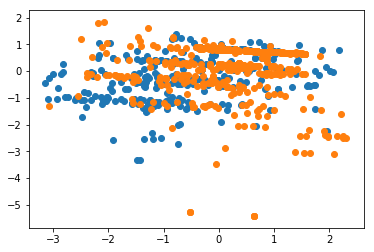

In [69]:
plt.scatter(y1[y==1],y2[y==1])
plt.scatter(y1[y==-1],y2[y==-1])

### 预测结果

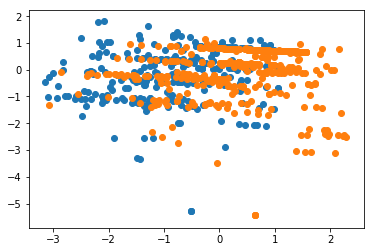

In [82]:
plt.scatter(y1[ret==1],y2[ret==1])
plt.scatter(y1[ret==-1],y2[ret==-1])